In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
from matplotlib import pyplot as plt
from datetime import datetime   

In [15]:
#Definicion de funciones

#Extraemos los datos  de Yahoo Finances, por el momento unicamente nos interesa el precio de cierre
def extract_date_yf(etiqueta,start_data,end_data,periocidad):

    df_aux = yf.download(etiqueta,start=start_data,end=end_data, interval = periocidad)
    return pd.DataFrame(df_aux['Close'])


#Creamos la primera estrategia y buscaremos evaluar su rentabilidad acumulada
def primera_estrategia(etiqueta,start_data,end_data,periocidad):

    #Extraccion de los datos
    df = extract_date_yf(etiqueta,start_data,end_data,periocidad)
    

    #Creacion de medias moviles (SECCION DE LOS INDICADORES)
    df['mv_rapida'] = df['Close'].rolling(30).mean()
    df['mv_lenta'] = df['Close'].rolling(60).mean()


    #Definimos una variable llamada "POSICION" que determina si compramos o vendemos
    df['posicion'] = np.nan

    df.loc[(df['mv_rapida'] > df['mv_lenta']) , 'posicion' ] = 1
    df.loc[(df['mv_rapida'] < df['mv_lenta'])  , 'posicion']  = -1


    #Porcentaje de variacion
    df['pct'] = df['Close'].pct_change()

    #Retorno obtenido en caso de seguir la posicion del dia anterior
    df['return'] = df['pct'] * df['posicion'].shift(1)

    #Retornamos el dataframe con todos los datos
    return df


#Mostramos el grafico del precio con los indicadores, el grafico de las posiciones abiertas y cerradas y las ganancias/perdidas acumuladas
def graficos(df):

    #==== GRAFICO NORMAL
    plt.style.use('dark_background')
    plt.figure(figsize=(15,8))

    #Configuracion de cada linea
    plt.plot(df['Close'], color="white", label='Precio de cierre')
    plt.plot(df['mv_rapida'], color='yellow', label='MV de 9')
    plt.plot(df['mv_lenta'], color='red', label='MV de 18')


    plt.legend(['Precio de cierre','MV rapida','MV lenta'])
    plt.xlabel("Frecuencia Diaria")
    plt.ylabel("Precio")

    plt.show()


    #=== GRAFICO DE POSICIONES ABIERTAS Y CERRADAS 

    #Lo que se hace aca es obtener los indices de cada posicion que tiene marcado 1 y -1
    idx_open = df.loc[df["posicion"] == 1].index
    idx_close = df.loc[df["posicion"] == -1].index


    # Configuración del estilo y tamaño
    plt.style.use('dark_background')
    plt.figure(figsize=(15,8))

    #Configuracion de lineas punteadas - Como tenemos los indice de los 1 y -1, para buscar la Y usamos loc con el indice y el precio de cierre 
    plt.scatter(idx_open, df.loc[idx_open]['Close'], color ="green", marker="^")
    plt.scatter(idx_close, df.loc[idx_close]['Close'], color ="red", marker="v")


    #Configuracion de cada linea
    plt.plot(df['Close'], color="white", label='Precio de cierre' , alpha = 0.35)
    plt.plot(df['mv_rapida'], color='yellow', label='MV de 9', alpha = 0.35)
    plt.plot(df['mv_lenta'], color='red', label='MV de 18',alpha = 0.35)

    plt.legend()
    plt.xlabel("Frecuencia Diaria")
    plt.ylabel("Precio")

    plt.show()


    #=== GRAFICO DE VARICIONES ACUMULADA
    plt.style.use('dark_background')
    plt.figure(figsize=(15,8))
    plt.plot(df['return'].cumsum() * 100)
    plt.show()
    




<H3>Indice sortino(IS):</H3>

* Si IS < 0, el promedio de las variaciones es negativo
* Si  0 < IS < 1, no es recomendable. Ya que el promedio no supera la desviacion estandar negativa.
* Si IS > 1, se recomienda invertir, ya que el promedio de los valores supera la variacion negativa (esto porque hay mas valores positivos).


In [16]:

def indice_sortino(df):

    #Obtencion de media y varianza
    u = df['pct'].mean()
    var = df['pct'][df['pct'] < 0].std() #Teniendo en cuenta las perdidas

    #Multiplicamos por 252 ya que es la cantidad de dias que la bolsa esta abierta en el año
    ind_sortino = np.sqrt(252)*(u / var)

    print(f"Indice Sortino: {ind_sortino}")

    
    """# Configuración del estilo y tamaño
    plt.style.use('dark_background')
    
    #Estudiamos la distancia de los datos respecto a la media, y la dispersion
    plt.figure(figsize=(10,10))
    plt.scatter(range(len(df['pct'])),df['pct'], alpha=0.35)

    #Graficamos el rango de la varianza, y la media
    plt.axhline(y = u - df['pct'].std(), color = "green", linestyle='dashed',label = "Desviacion de todos los datos")
    plt.axhline(y = u, color = "red", linestyle='dashed')
    plt.axhline(y = -(u-df['pct'].std()),color = "green", linestyle='dashed')

    #Desviacion de los valores negativos
    plt.axhline(y = u - var, color = "purple", linestyle='dashed',label = "Desviacion de los rendimientos negativos")
    plt.axhline(y = -(u-var),color = "purple", linestyle='dashed')

    plt.legend()
    plt.show()"""

<H3> Indice Beta(IB): </h3>

Nos habla del nivel de relacion que existe entre el mercado y una accion en particular. Nos indica cuanto varia una accion
en base a la variacion que sufre el mercado. 

Ejemplo: Si IB = 0.7, quiere decir que si el MERCADO se mueve un 1%, la accion varia un 0.7%,

*  Si IB > 1, no se recomienda la accion. Es mas volatil que el mercado.
* Si IB < 1, se recomienda porque la accion varia menos que el mercado.

In [17]:
def indice_beta(df,fecha_inicio,fecha_fin,frecuencia):

    #Extraemos los datos del SP500 - Calculamos los porcentaje de variaciones
    df_sp500 = extract_date_yf("^GSPC",fecha_inicio,fecha_fin,frecuencia)
    df_sp500['pct'] = df_sp500['Close'].pct_change(1)


    #Concatenamos los porcentajes de la accion y del indice de mercado
    var = pd.concat((df['pct'],df_sp500['pct']),axis=1).dropna()

    """"
    rowvar = False, ya que esto nos genera una comparacion por fila. Necesitamos una 
    Comparacion de toda la columna con la otra.
    
    Obtendremos una matriz de 4 elementos:
        - elemento (0,0) y (1,1) son VARIANZAS
        - elemento (0,1) y (1,0) son la COVARIANZA --> Este es el objetivo
    """
    matriz_varianzas = np.cov(var,rowvar=False)
    
    #Obtenemos de la matriz la covarianza. Y la Varianza del activo
    covarianza_activos = matriz_varianzas[1,0]

    #Indice beta
    ib = covarianza_activos / np.var(df['pct'])

    print(f"El indice BETA es: {ib:.3f}")

    return ib


<h3> Valor CAMP </h3>

Con este valor tratamos de definir el nivel de retorno en base al riesgo/beneficio asumido respecto al mercado.

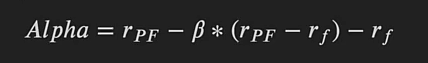

Se simplicada quedando: r(pf) - b * r(pf) = r(pf) * (1-b)

* r(pf) es el rendimiento esperado del mercado, que es el promedio de las variaciones porcentuales a lo largo del año.
* b es beta, que mide la relacion entre activo y mercado.

El valor se interpeta: 

* Si el valor es mayor a 0. Quiere decir que la rentabilidad obtenida es mayor asumiendo el mismo riesgo que el mercado.
* Si es menor a 0. Quiere decir que la rentabilidad obtenida es menor, asumiendo el mismo riesgo que el mercado.

In [18]:
def valor_camp(df,beta):

    #Obtencion de la media de las variaciones porcentuales del activo
    u = df['pct'].dropna().mean()

    #Se multiplica por 252 por una cuestion de anualizar la formula
    alpha = (252 * u * (1 - beta)) * 100

    print(f"El valor CAMP es: {alpha:.3f}%")

    return alpha



<h1> Creacion, evaluacion y visualizacion de la estrategia planteada </h1>

In [19]:
#Estrategia que aplica la apertura de posiciones y su mantenimiento en base a un stoploss, y profit.

"""
Probramos establecer "estados" para la posiciones.
2 = cerrada
1 = abierta o manteniendo una posicion 
0 = no hacer nada.

¿Como funciona este script? 

Lo primero que hacemos es crear las MV, y luego eliminar todos valores nulos,
de esta forma el trabajo es mas comodo.
Luego, evaluamos la estrategia, donde en que se den las señales de compra, se comprara.

--> La variable compra determina si compramos o vendemos. compra == True si ya compramos, compra == False si no compramos / vendimos.

En caso de que se de la compra:
Al realizarse la compra se deja la posicion abierta hasta que el stoploss sea atravesado (porcentaje del precio de cierre).
En esta etapa puede pasar varias cosas:


1 - Salta el stoploss
    Al saltar el stoploss no queda mas que vender.

2 - No salta el stoploss
    Al no saltar el stoploss quiere decir que estamos en posicion neutral, y se evalua el stoploss. 
        a - si el precio con el que se establecio el stoploss es superado, entonces se asigna un nuevo stoploss.
        b - si el precio con el que se establecio el stoploss no es superado, entonces no se asigna un nuevo stoploss. 

"""


def estrategy_profit_stoploss(etiqueta,start_data,end_data,periocidad,stoploss):

    #Extraccion de los datos
    df = extract_date_yf(etiqueta,start_data,end_data,periocidad)

    #Le quitamos el indice al dataframe para manipular el indice con numeros, al final lo agregamos de nuevo
    df = df.reset_index()

    #Porcentaje de variacion
    df['pct'] = df['Close'].pct_change()*100

    #Creacion de medias moviles (SECCION DE LOS INDICADORES)
    df['mv_rapida'] = df['Close'].rolling(20).mean()
    df['mv_lenta'] = df['Close'].rolling(60).mean()
    
    #Eliminacion de valores nulos
    df = df.dropna()

    #Lista que contiene la posicion. Valores explicados arriba
    lista_posicion = list()

    #precio que se toma de referencia para el stoploss
    precio_tomado = None

    #Porcentaje de perdida considerado para la venta del activo
    precio_stoploss = None

    #Banderas de compra | venta
    compra = False

    #valores stoplos
    list_stoploss = list()

    #Stoploss acompañado de precio de venta - almacenamos el par [ultimo_stoploss,precio_venta]
    list_stoploss_previo_venta = list()
    
    for index,raw in df.iterrows():
        
        if raw['mv_rapida'] > raw['mv_lenta']: #Si la mv rapida atraviesa la lenta - comprar
            
            if compra == False:
        
                #Definimos el stoploss en base al precio
                precio_tomado = raw['Close']
                precio_stoploss = raw['Close'] * (1 - (stoploss/100))
                list_stoploss.append(precio_stoploss)
                #Realizamos una compra, ahora queda cortar con el stoploss
                compra = True

                #Agregamos una posicion
                lista_posicion.append(1)

            else:# -- Se ejecuta solo si ya se realizo una compra

                if compra == True:    

                    if raw['Close'] <= precio_stoploss: #--> Si el precio pasa el stoploss se vende
                        lista_posicion.append(2) #--> posicion de venta
                        compra = False #--> Habilitamos la compra nuevamente

                        #Almacenamos el ultimo precio de stoploss previo a la venta, y el precio de venta.
                        list_stoploss_previo_venta.append([precio_stoploss,raw['Close']])

                        precio_stoploss = None



                    #Si no salta el stoploss, estamos en posicion neutral. Tenemos que evaluar nuevamente el stoploss.
                    else:

                        #Si el precio subio, entonces asignamos nuevo stoploss
                        if raw['Close'] > precio_tomado:
                            precio_stoploss = raw['Close'] * (1 - (stoploss/100))
                            list_stoploss.append(precio_stoploss)
                            lista_posicion.append(0) #--> Posicion neutral
                            precio_tomado = raw['Close']

                        else: #Si el precio bajo, mantenemos el stoploss
                            lista_posicion.append(0) #--> Posicion neutral
                else:
                    lista_posicion.append(0)

        else:#Si la MV lenta esta por encima de la lenta

            if compra == True:    

                if raw['Close'] <= precio_stoploss:# VENDEMOS solo si se produjo una compra
                    lista_posicion.append(2) #--> Vendemos
                    compra = False#--> Habilitamos la compra nuevamente


                    #Almacenamos el ultimo precio de stoploss previo a la venta, y el precio de venta.
                    list_stoploss_previo_venta.append([precio_stoploss,raw['Close']])
                    
                    #Anulamos el stoploss hasta la siguiente orden de compra
                    precio_stoploss = None


                else: #Si no pasa el stoploss - mantener neutral

                    #Si el precio subio, entonces asignamos nuevo stoploss
                    if raw['Close'] > precio_tomado:
                        precio_stoploss = raw['Close'] * (1 - (stoploss/100))
                        list_stoploss.append(precio_stoploss)
                        lista_posicion.append(0) #--> Posicion neutral
                        precio_tomado = raw['Close']
                    else:
                        lista_posicion.append(0) #--> Posicion neutral
            else:
                lista_posicion.append(0) #--> Posicion neutral




    print("tamaño de lista_posicion:",len(lista_posicion))


    #Definimos una variable llamada "POSICION" que determina si compramos o vendemos
    df['posicion'] = lista_posicion    


    return df,list_stoploss,list_stoploss_previo_venta


#Objetivo: Evaluamos el precio de compra, y la variacion con la venta. De esta forma determinamos porcentualmente si ganamos o perdimos
def evaluar_ganancias_perdidas(df):

    #Df historico de compra y de ventas
    df_historico = pd.DataFrame(columns=['fecha_compra','fecha_venta','precio_compra','precio_venta','variacion'])
    
    #Fecha de compra y venta
    fecha_compra = list()
    fecha_venta = list()

    #Precio al que se compro y al que se vendio
    lista_compra = list()
    lista_venta = list()

    #Lista de variaciones
    variaciones = list()

    #Iteramos sobre los precio de cierre, buscando las posiciones de compra y venta
    for index,row in df.iterrows():

        if row['posicion'] == 1:
            lista_compra.append(row['Close'])
            fecha_compra.append(row['Date'])

            
        if row['posicion'] == 2:
            lista_venta.append(row['Close'])
            fecha_venta.append(row['Date'])


    #Revisamos si la lista de compra, y la lista de la fecha de compra, posee un elemento mas, en este caso lo eliminamos para que no haya una "posicion abieta"
    if len(lista_compra) > len(lista_venta):
        lista_compra.pop()
        fecha_compra.pop()

    #Construccion de dataframe
    df_historico['fecha_compra'] = fecha_compra
    df_historico['fecha_venta'] = fecha_venta
    df_historico['precio_compra'] = lista_compra
    df_historico['precio_venta'] = lista_venta
    
    #Calculamos las variaciones
    df_historico['variacion'] = ((df_historico['precio_venta'] - df_historico['precio_compra']) / df_historico['precio_compra'] ) * 100


    #Cantidad de veces que se gano, y que se perdio
    cant_ganar = len(df_historico[df_historico['variacion'] > 0])
    cant_perder = len(df_historico[df_historico['variacion'] < 0])

    probabilidad_frecuentista = cant_ganar / (cant_ganar + cant_perder)

    print(f"* La cantidad de veces que se GANO {cant_ganar}")
    print(f"* La cantidad de veces que se PERDIO {cant_perder}")
    print(f'* La probabilidad de exito es: {probabilidad_frecuentista:.2f}')

    print(df_historico)

    return df_historico['variacion']


#Objetivo: estudiar el exceso que hubo desde el ultimo precio de venta, y el stoploss definido. Es necesario analizarlo, ya
#que como estamos trabajando con el precio de cierre, 
def exceso_stoploss(list_stoploss_previo_venta):
    for item in list_stoploss_previo_venta:
        
        variacion = ((item[1] - item[0]) / item[1] ) * 100

        print(f'* Ultimo stoploss {item[0]:.2f} - Precio de venta {item[1]:.2f} - Exceso de perdida: {variacion:.2f}')  



<H1> Visualizaciones grafica de los resultados </H1>

In [20]:
#Visualizacion de los puntos de compra y venta - acompañado del grafico del stoploss dinamico
def visualizacion_prueba(df,lista_stoploss):


    tamaño_scater = len(df)

    plt.style.use('dark_background')
    plt.figure(figsize=(20,20))

    #Precio normal
    plt.plot(df['Close'], color = "white", label = "Precio de cierre", alpha = 0.35)
    plt.plot(df['mv_rapida'], color = "yellow", label = "Media rapida", alpha = 0.35)
    plt.plot(df['mv_lenta'], color = "red", label = "Media lenta", alpha = 0.35)


    #=== Puntos de compra y venta

    #Recorremos las posiciones y cargamos en la lista los colores asignados a cada posicion
    lista_colores = []

    for posicion in df['posicion']:
         
        #if posicion == 0: #No se hizo nada
        #   lista_colores.append("blue")
        if posicion == 1:
            lista_colores.append("green")
        elif posicion == 2:
            lista_colores.append("red")
        

    plt.scatter(df.index[df['posicion'] != 0],df['Close'][df['posicion'] != 0], c=lista_colores,label = "Verde: compra | azul: Neutral | rojo: Venta ")

    plt.legend()
    plt.ylim(min(df['Close']),max(df['Close']))
    plt.show()

    plt.scatter(range(0,len(lista_stoploss)),lista_stoploss)
    plt.show()

#Objetivo: graficar las variaciones entre los puntos de compra y venta
def grafico_variaciones(variaciones):

    plt.plot(variaciones, marker = ".",color = "w", mfc = "b",ms = 10)

    plt.title("Variaciones porcentuales obtenidad de cada compra/venta")
    plt.ylabel("Variacion porcentual de ganancia/perdida")
    plt.xlabel("N° de posicion de compra/venta")

<H1> MAIN DE EJECUCION </H1>

In [21]:
fecha_actual = str(datetime.now().year)+"-"+str(datetime.now().month)+"-"+str(datetime.now().day)

fecha_inicio = "2020-01-01"
fecha_fin = "2024-01-01"
periocidad = "1d"
stoploss = 5 #--> Porcentualmente hablando

df,lista_stoploss,list_stoploss_previo_venta = estrategy_profit_stoploss('CAT',fecha_inicio,fecha_actual,periocidad,stoploss)
variaciones = evaluar_ganancias_perdidas(df)


[*********************100%%**********************]  1 of 1 completed

tamaño de lista_posicion: 975
* La cantidad de veces que se GANO 12
* La cantidad de veces que se PERDIO 19
* La probabilidad de exito es: 0.39
   fecha_compra fecha_venta  precio_compra  precio_venta  variacion
0    2020-05-26  2020-06-11     117.410004    121.550003   3.526104
1    2020-06-12  2020-06-24     123.150002    122.059998  -0.885103
2    2020-06-25  2020-07-31     124.709999    132.880005   6.551203
3    2020-08-03  2020-09-21     131.779999    145.330002  10.282291
4    2020-09-22  2020-10-27     147.149994    157.910004   7.312273
5    2020-10-28  2020-11-04     151.160004    155.229996   2.692506
6    2020-11-05  2021-01-25     163.089996    187.339996  14.869091
7    2021-01-26  2021-03-23     187.210007    218.250000  16.580307
8    2021-03-24  2021-06-10     221.229996    225.729996   2.034082
9    2021-06-11  2021-06-17     220.699997    209.449997  -5.097417
10   2021-09-07  2021-09-20     208.229996    190.820007  -8.360942
11   2021-11-10  2021-11-26     206.6699

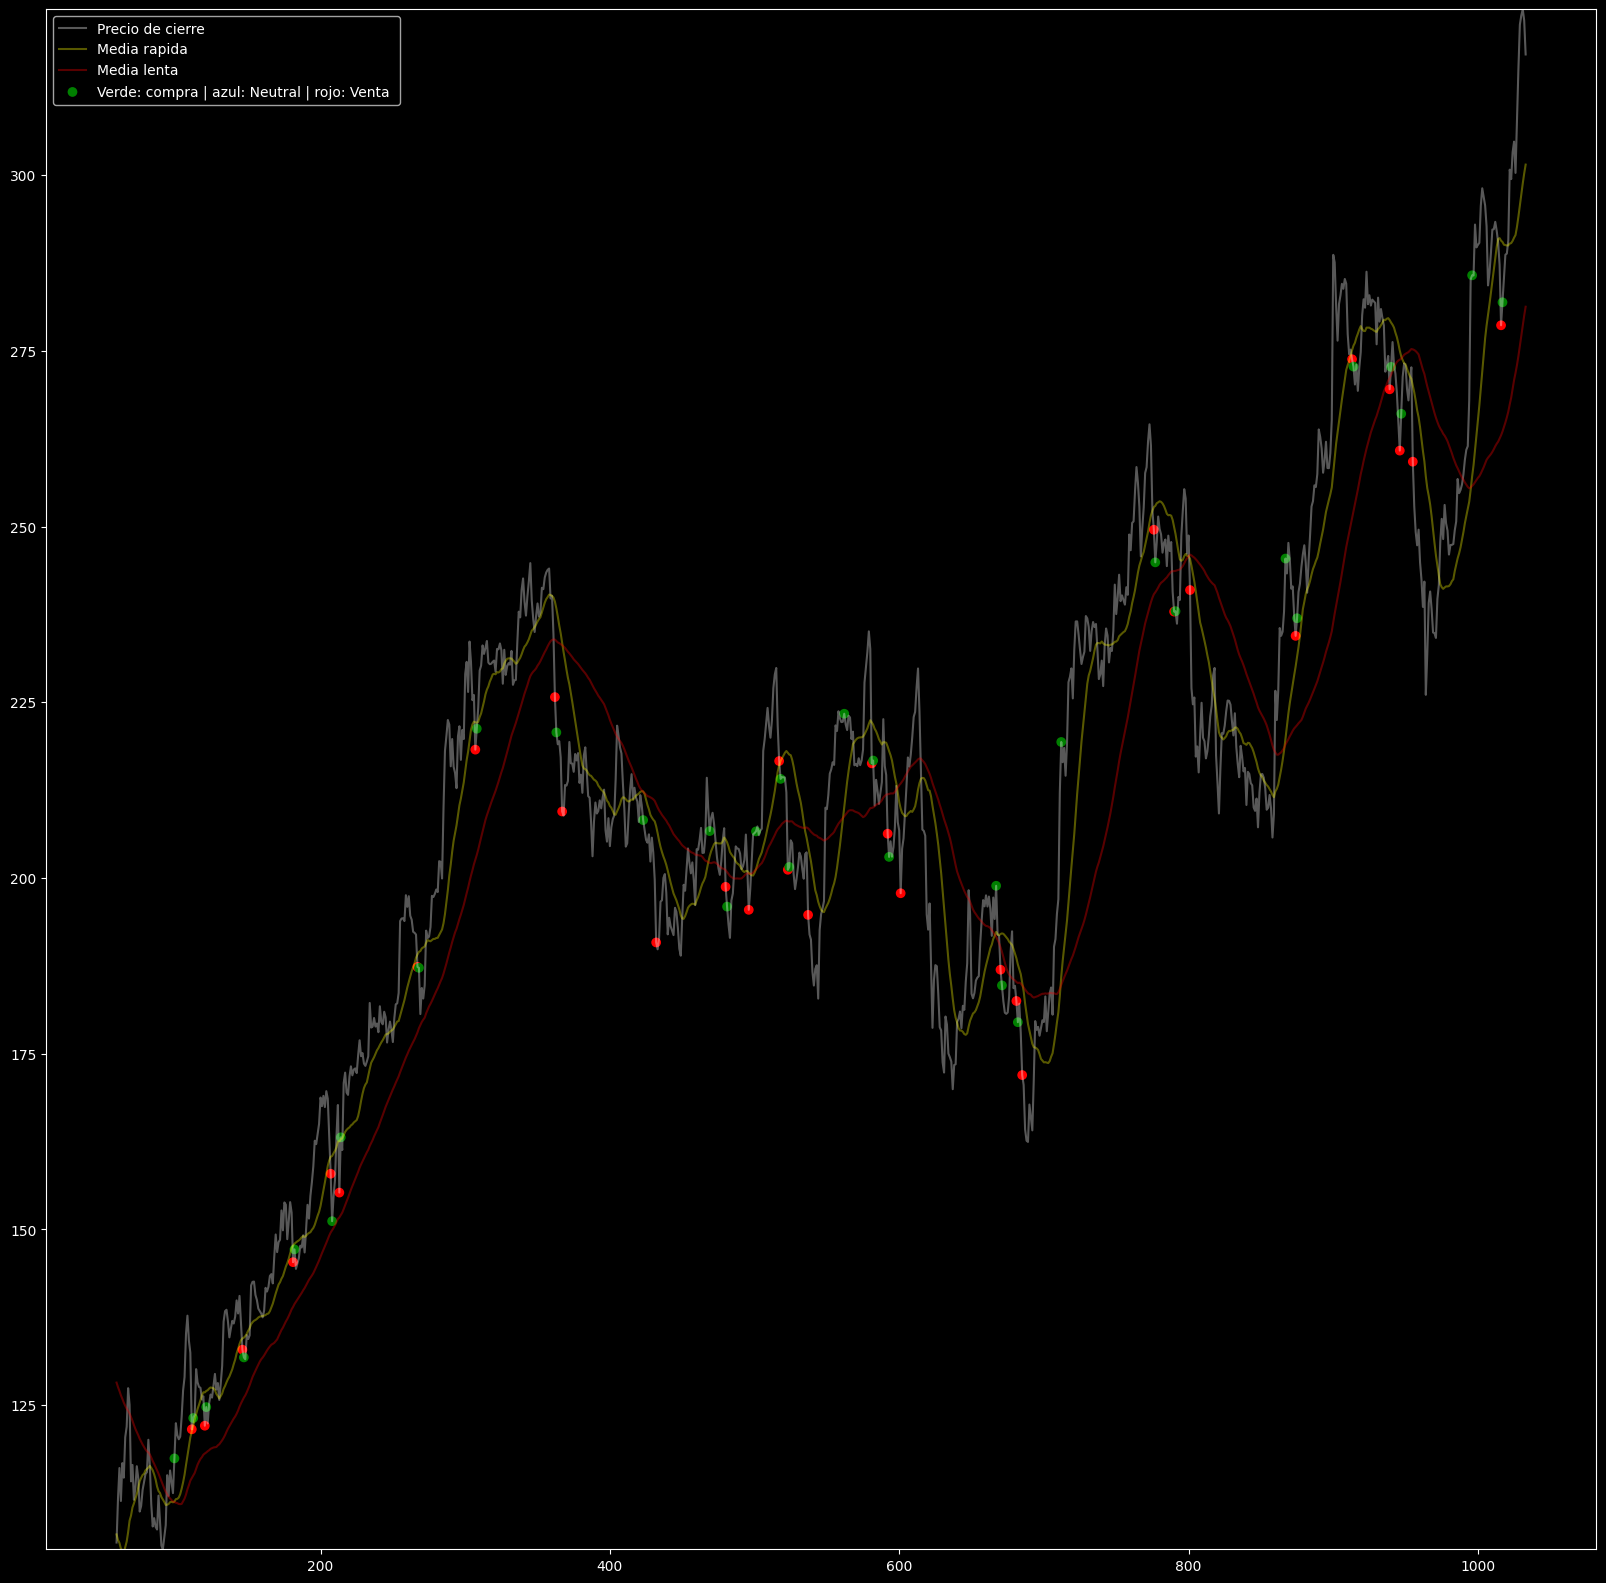

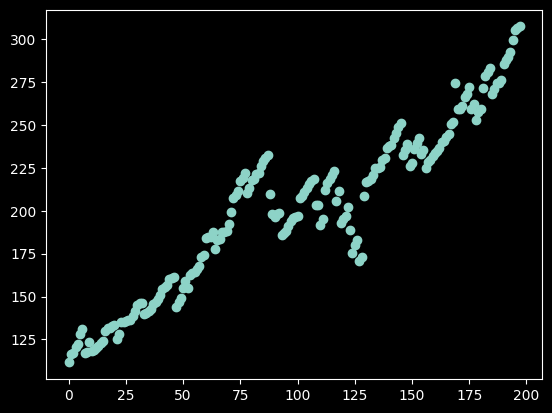

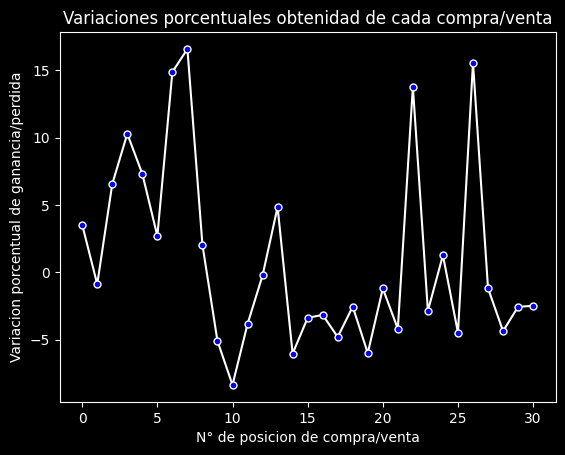

In [22]:
visualizacion_prueba(df,lista_stoploss)
grafico_variaciones(variaciones)
